In [ ]:
# ENHANCED MOTOR LEARNING ANALYSIS WITH STRIDE CHANGE DISTRIBUTION
# Incorporates the stride change distribution plotting functionality
# ==============================================================================

import os
import re
import pickle
import tempfile
import webbrowser
from collections import defaultdict
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, mannwhitneyu, gaussian_kde
import statsmodels.formula.api as smf

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score, 
                             precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

from IPython.display import display, HTML
from tqdm import tqdm

In [ ]:
# 1. CONFIGURATION
# ==============================================================================

class Config:
    """Configuration settings for the motor learning analysis."""
    
    # File processing
    MIN_COMPLETE_STRIDES = 20
    PROCESSED_DATA_FILE = 'processed_data.pkl'
    FIGURES_DIR = Path('figures')
    
    # Trial type mappings
    TRIAL_TYPE_MAPPING = {
        'primer': 'vis1',
        'trial': 'invis', 
        'vis': 'vis2',
        'pref': 'pref'
    }
    
    # Analysis parameters
    MOTOR_NOISE_THRESHOLD = 0.3
    SUCCESS_RATE_THRESHOLD = 0.68
    TARGET_SIZE_THRESHOLD = 0.31
    MAX_STRIDES_THRESHOLD = 415

In [ ]:
# 2. UTILITY FUNCTIONS
# ==============================================================================

class DataUtils:
    """Utility functions for data processing."""
    
    @staticmethod
    def load_and_validate_file(file_path: Path, required_cols: set = None) -> Optional[pd.DataFrame]:
        """Load and validate a single data file."""
        try:
            df = pd.read_csv(file_path, sep='\t')
            
            if required_cols and not required_cols.issubset(df.columns):
                return None
                
            # Basic cleaning
            if 'Stride Number' in df.columns:
                df['Stride Number'] = pd.to_numeric(df['Stride Number'], errors='coerce')
                df = df.dropna(subset=['Stride Number'])
                df = df.drop_duplicates(subset=['Stride Number'])
            
            return df if not df.empty else None
            
        except Exception as e:
            print(f"❌ Error loading {file_path.name}: {str(e)}")
            return None

    @staticmethod
    def detect_anomalies(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
        """Detect and flag anomalies in stride data."""
        if df is None or df.empty:
            return df, {}

        df = df.copy()
        df['Anomalous'] = False
        anomalies = {}

        # Time-based anomalies
        time_col = next((col for col in ['Time', 'Timestamp', 'Time (s)'] 
                        if col in df.columns), None)
        if time_col:
            df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
            time_diff = df[time_col].diff()
            jump_mask = time_diff > time_diff.quantile(0.99) * 5
            
            for idx in df.index[jump_mask.fillna(False)]:
                df.at[idx, 'Anomalous'] = True
                anomalies.setdefault(idx, []).append('time_jump')

        # Sum of gains and steps anomalies
        if 'Sum of gains and steps' in df.columns:
            high_mask = df['Sum of gains and steps'] > 4
            zero_mask = df['Sum of gains and steps'] == 0

            for idx in df.index[high_mask]:
                df.at[idx, 'Anomalous'] = True
                anomalies.setdefault(idx, []).append('sum_gain_step_high')
            
            for idx in df.index[zero_mask]:
                df.at[idx, 'Anomalous'] = True
                anomalies.setdefault(idx, []).append('sum_gain_step_zero')

        # Duplicate rows
        duplicated_mask = df.duplicated()
        for idx in df.index[duplicated_mask]:
            df.at[idx, 'Anomalous'] = True
            anomalies.setdefault(idx, []).append('duplicate_row')

        return df, anomalies

In [ ]:
# 3. TRIAL PROCESSING
# ==============================================================================

class TrialProcessor:
    """Handles loading, combining, and processing of trial data."""
    
    def __init__(self, debug: bool = True):
        self.debug = debug
        
    def find_and_combine_trial_files(self, subject_dir: Path, trial_prefix: str) -> Optional[pd.DataFrame]:
        """Find and combine trial files for a given trial type."""
        all_files = sorted(subject_dir.glob(f"{trial_prefix}*.txt"))
        
        if not all_files:
            if self.debug:
                print(f"  ⚠️ No files found for {trial_prefix}")
            return None
        
        # Special handling for preference trials
        if trial_prefix == 'pref':
            return self._handle_pref_trial(all_files)
        
        # Single file case
        if len(all_files) == 1:
            return DataUtils.load_and_validate_file(all_files[0])
        
        # Multiple files - combine them
        return self._combine_trial_fragments(all_files)
    
    def _handle_pref_trial(self, files: List[Path]) -> Optional[pd.DataFrame]:
        """Handle preference trial - select largest file."""
        largest_file = max(files, key=lambda f: f.stat().st_size)
        if self.debug and len(files) > 1:
            print(f"  ⚡ pref trial - selected largest of {len(files)} files")
        return DataUtils.load_and_validate_file(largest_file)
    
    def _combine_trial_fragments(self, files: List[Path]) -> Optional[pd.DataFrame]:
        """Combine multiple trial fragments intelligently."""
        file_info = []
        
        for f in files:
            try:
                with open(f, 'r') as file:
                    header = file.readline().strip().split('\t')
                    stride_col = next((i for i, col in enumerate(header) 
                                     if 'stride' in col.lower() and 
                                     ('num' in col.lower() or 'no' in col.lower())), None)
                    
                    if stride_col is None:
                        continue
                    
                    # Get stride range
                    lines = file.readlines()
                    first_stride = float(lines[0].split('\t')[stride_col])
                    last_stride = float(lines[-1].split('\t')[stride_col])
                    
                    file_info.append({
                        'path': f,
                        'first': first_stride,
                        'last': last_stride,
                        'size': f.stat().st_size
                    })
            except Exception:
                continue
        
        if not file_info:
            return DataUtils.load_and_validate_file(max(files, key=lambda f: f.stat().st_size))
        
        # Find best continuous sequence
        file_info.sort(key=lambda x: x['first'])
        best_sequence = self._find_best_sequence(file_info)
        
        if len(best_sequence) >= 2:
            return self._merge_files([f['path'] for f in best_sequence])
        
        # Fallback to largest file
        return DataUtils.load_and_validate_file(max(file_info, key=lambda x: x['size'])['path'])
    
    def _find_best_sequence(self, file_info: List[Dict]) -> List[Dict]:
        """Find the best continuous sequence of files."""
        best_sequence = []
        current_sequence = [file_info[0]]
        
        for file_data in file_info[1:]:
            if file_data['first'] == current_sequence[-1]['last'] + 1:
                current_sequence.append(file_data)
            else:
                if len(current_sequence) > len(best_sequence):
                    best_sequence = current_sequence
                current_sequence = [file_data]
        
        return max([best_sequence, current_sequence], key=len)
    
    def _merge_files(self, file_paths: List[Path]) -> Optional[pd.DataFrame]:
        """Merge multiple files into a single DataFrame."""
        dfs = []
        for f in file_paths:
            df = DataUtils.load_and_validate_file(f)
            if df is not None:
                dfs.append(df)
        
        if not dfs:
            return None
        
        combined = pd.concat(dfs, ignore_index=True)
        
        # Clean and sort
        if 'Stride Number' in combined.columns:
            combined = combined.sort_values('Stride Number')
            combined = combined.drop_duplicates('Stride Number')
        
        return combined

In [ ]:
# 4. MAIN DATA MANAGER
# ==============================================================================

class MotorLearningDataManager:
    """Main class for managing motor learning data."""
    
    def __init__(self, metadata_path: str, data_root_dir: str, 
                 force_reprocess: bool = False, debug: bool = True):
        self.metadata_path = metadata_path
        self.data_root_dir = data_root_dir
        self.debug = debug
        
        # Initialize components
        self.trial_processor = TrialProcessor(debug=debug)
        self.config = Config()
        
        # Data storage
        self.metadata = None
        self.processed_data = {}
        
        # Create output directory
        os.makedirs(self.config.FIGURES_DIR, exist_ok=True)
        
        # Load or process data
        if not force_reprocess and os.path.exists(self.config.PROCESSED_DATA_FILE):
            self._load_processed_data()
        else:
            self._process_all_data()
            self._save_processed_data()
    
    def _load_processed_data(self):
        """Load previously processed data."""
        with open(self.config.PROCESSED_DATA_FILE, 'rb') as f:
            self.processed_data = pickle.load(f)
            
        # Rebuild metadata DataFrame
        self.metadata = pd.DataFrame.from_dict(
            {subj: data['metadata'] for subj, data in self.processed_data.items()}, 
            orient='index'
        )
    
    def _save_processed_data(self):
        """Save processed data."""
        with open(self.config.PROCESSED_DATA_FILE, 'wb') as f:
            pickle.dump(self.processed_data, f)
    
    def _process_all_data(self):
        """Process all subject data."""
        self._load_metadata()
        total_subjects = len(self.metadata)
        
        if self.debug:
            print(f"🔄 Processing {total_subjects} subjects...")
        
        for i, (_, row) in enumerate(self.metadata.iterrows(), 1):
            subject_id = row['ID']
            if self.debug:
                print(f"\n[{i}/{total_subjects}] Processing {subject_id}...")
            
            subject_data = self._process_subject_data(subject_id, row)
            if subject_data:
                self.processed_data[subject_id] = subject_data
    
    def _load_metadata(self):
        """Load and clean metadata."""
        self.metadata = pd.read_csv(self.metadata_path)
        self.metadata['DOB'] = pd.to_datetime(self.metadata['DOB'], errors='coerce')
        self.metadata['Session Date'] = pd.to_datetime(self.metadata['Session Date'], errors='coerce')
        self.metadata = self.metadata.dropna(subset=['ID', 'age_months'])
    
    def _process_subject_data(self, subject_id: str, metadata_row: pd.Series) -> Optional[Dict]:
        """Process data for a single subject."""
        subject_dir = Path(self.data_root_dir) / subject_id
        if not subject_dir.exists():
            if self.debug:
                print(f"❌ Directory not found: {subject_dir}")
            return None
        
        trial_data = {}
        
        for original_type in ['primer', 'trial', 'vis', 'pref']:
            try:
                # Load trial data
                df = self.trial_processor.find_and_combine_trial_files(subject_dir, original_type)
                
                if df is not None:
                    # Process the data
                    processed_df, anomalies = self._process_trial_data(df, original_type)
                    
                    # Store with mapped name
                    new_type = self.config.TRIAL_TYPE_MAPPING[original_type]
                    trial_data[new_type] = {
                        'data': processed_df,
                        'anomalies': anomalies
                    }
                    
            except Exception as e:
                print(f"Error processing {subject_id}/{original_type}: {str(e)}")
                continue
        
        return {
            'metadata': metadata_row.to_dict(),
            'trial_data': trial_data
        } if trial_data else None
    
    def _process_trial_data(self, df: pd.DataFrame, trial_type: str) -> Tuple[pd.DataFrame, Dict]:
        """Process trial data and calculate metrics."""
        if df is None or df.empty:
            return None, {}
        
        # Skip processing for pref trials (just clean duplicates)
        if trial_type == 'pref':
            df = df.drop_duplicates(subset='Left heel strike', keep='last')
            return df, {}
        
        # Validate required columns
        required_cols = ['Stride Number', 'Success', 'Upper bound success', 
                        'Lower bound success', 'Constant']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"Missing required columns: {missing_cols}")
            return None, {}
        
        try:
            # Process trial data
            df = df.sort_values('Stride Number')
            df['Target size'] = df['Upper bound success'] - df['Lower bound success']
            df = df.drop_duplicates(subset='Stride Number', keep='last')
            
            # Scale sum of gains and steps
            if 'Sum of gains and steps' in df.columns:
                df['Sum of gains and steps'] = 1.5 * df['Sum of gains and steps']
            
            # Detect anomalies
            df, anomalies = DataUtils.detect_anomalies(df)
            
            return df, anomalies
            
        except Exception as e:
            print(f"Error processing {trial_type} data: {str(e)}")
            return None, {}
    
    def get_trial_df(self, trial_dict: Dict) -> Optional[pd.DataFrame]:
        """Get trial data from trial dictionary."""
        if trial_dict and 'data' in trial_dict:
            return trial_dict['data']
        return None
    
    def filter_trials(self, max_target_size=None, min_age=None, max_age=None, 
                     required_trial_types=None, min_strides=None, max_strides=None):
        """Filter trials based on specified criteria."""
        filtered_data = {}
        
        for subject_id, subject_data in self.processed_data.items():
            # SIMPLIFIED AGE FILTERING - always use age_months/12
            age = subject_data['metadata']['age_months'] / 12
            if min_age is not None and age < min_age:
                continue
            if max_age is not None and age > max_age:
                continue
            
            # Check required trial types
            if required_trial_types:
                missing_trials = [
                    t for t in required_trial_types 
                    if t not in subject_data['trial_data'] or 
                       subject_data['trial_data'][t] is None or
                       subject_data['trial_data'][t]['data'] is None
                ]
                if missing_trials:
                    continue
            
            # Check other criteria
            valid_subject = True
            filtered_trial_data = {}
            
            for trial_type, trial_dict in subject_data['trial_data'].items():
                if trial_dict and trial_dict['data'] is not None:
                    df = trial_dict['data']
                    
                    # Apply filters
                    if (max_target_size is not None and 
                        'Target size' in df.columns and 
                        df['Target size'].min() > max_target_size):
                        valid_subject = False
                        break
                    
                    n_strides = len(df)
                    if ((min_strides is not None and n_strides < min_strides) or
                        (max_strides is not None and n_strides > max_strides)):
                        valid_subject = False
                        break
                    
                    # Include valid trial
                    filtered_trial_data[trial_type] = {
                        'data': df.copy(),
                        'anomalies': trial_dict['anomalies'].copy()
                    }
            
            if valid_subject and filtered_trial_data:
                filtered_data[subject_id] = {
                    'metadata': subject_data['metadata'].copy(),
                    'trial_data': filtered_trial_data
                }
        
        # Create new instance with filtered data
        new_instance = MotorLearningDataManager.__new__(MotorLearningDataManager)
        new_instance.config = self.config
        new_instance.trial_processor = self.trial_processor
        new_instance.metadata_path = self.metadata_path
        new_instance.data_root_dir = self.data_root_dir
        new_instance.debug = self.debug
        new_instance.processed_data = filtered_data
        new_instance.metadata = pd.DataFrame.from_dict(
            {subj: data['metadata'] for subj, data in filtered_data.items()}, 
            orient='index'
        )
        
        return new_instance
    
    def get_trial_data(self, subject_id: str, trial_type: str) -> Optional[pd.DataFrame]:
        """Get trial data for a specific subject and trial type."""
        try:
            trial_dict = self.processed_data[subject_id]['trial_data'][trial_type]
            return trial_dict['data'] if trial_dict else None
        except KeyError:
            return None
    
    def print_summary(self):
        """Print summary statistics of the dataset."""
        print(f"📊 Dataset Summary:")
        print(f"Total subjects: {len(self.processed_data)}")
        
        if self.metadata is not None:
            # SIMPLIFIED AGE DISPLAY - always use age_months/12
            ages = self.metadata['age_months'] / 12
            print(f"Age range: {ages.min():.1f} - {ages.max():.1f} years")
            print(f"Mean age: {ages.mean():.1f} years")
        
        # Trial type counts
        trial_counts = defaultdict(int)
        for subject_data in self.processed_data.values():
            for trial_type in subject_data['trial_data'].keys():
                trial_counts[trial_type] += 1
        
        print(f"Trial type counts: {dict(trial_counts)}")

In [ ]:
# 5. CORRECTED METRICS CALCULATOR
# ==============================================================================

class MetricsCalculator:
    """Handles calculation of performance metrics with corrected column naming."""
    
    def __init__(self, data_manager: MotorLearningDataManager):
        self.data_manager = data_manager
        self.config = Config()
    
    def calculate_all_metrics(self) -> pd.DataFrame:
        """Calculate comprehensive performance metrics for all subjects."""
        results = []
        
        print(f"🧮 Calculating metrics for {len(self.data_manager.processed_data)} subjects...")
        
        for i, (subject_id, data) in enumerate(self.data_manager.processed_data.items(), 1):
            if i % 20 == 0:
                print(f"   Processed {i}/{len(self.data_manager.processed_data)} subjects...")
            
            try:
                subject_result = self._calculate_subject_metrics(subject_id, data)
                if subject_result:
                    results.append(subject_result)
            except Exception as e:
                print(f"   ⚠️ Error processing {subject_id}: {str(e)}")
                continue
        
        if not results:
            print("❌ No valid metrics calculated!")
            return pd.DataFrame()
        
        df = pd.DataFrame(results).infer_objects()
        print(f"✅ Successfully calculated metrics for {len(df)} subjects")
        
        # Print age and column summary
        if 'age' in df.columns:
            ages = df['age'].dropna()
            print(f"📊 Age range: {ages.min():.1f} - {ages.max():.1f} years")
        
        sr_cols = [col for col in df.columns if '_sr_' in col]
        print(f"🎯 Success rate columns created: {sr_cols}")
        
        return df
    
    def _calculate_subject_metrics(self, subject_id: str, subject_data: Dict) -> Optional[Dict]:
        """Calculate metrics for a single subject with simplified age handling."""
        
        # SIMPLIFIED: Only store age as age_months/12, call it 'age'
        result = {
            'ID': subject_id,
            'age': subject_data['metadata'].get('age_months', np.nan) / 12,  # Single age field
            'session_date': subject_data['metadata'].get('Session Date')
        }
        
        # Process each trial type
        for trial_type in ['vis1', 'invis', 'vis2']:
            try:
                trial_dict = subject_data['trial_data'].get(trial_type)
                df = trial_dict['data'] if trial_dict else None
                
                if df is None or df.empty or 'Success' not in df.columns:
                    continue
                
                # Calculate metrics for both conditions
                for condition in ['max', 'min']:
                    period_data, indices = self._get_period_data(df, condition)
                    if period_data is not None and not period_data.empty:
                        metrics = self._calculate_period_metrics(period_data, trial_type, condition)
                        result.update(metrics)
                        result[f'{trial_type}_{condition}_const_indices'] = indices
                
                # Add trial metadata - ONLY if df is not None
                if df is not None:
                    result.update({
                        f'{trial_type}_min_target_size': df['Target size'].min() if 'Target size' in df.columns else None,
                        f'{trial_type}_max_constant': df['Constant'].max() if 'Constant' in df.columns else None,
                        f'{trial_type}_min_constant': df['Constant'].min() if 'Constant' in df.columns else None
                    })
                    
                    # Order information for invis trials
                    if trial_type == 'invis':
                        result.update(self._calculate_condition_order(df))
                        
            except Exception as e:
                continue
        
        # Process preference trial
        try:
            pref_metrics = self._calculate_preference_metrics(subject_data['trial_data'].get('pref'))
            result.update(pref_metrics)
        except Exception as e:
            result.update({'mot_noise': None, 'pref_asymmetry': None})
        
        return result
    
    def _get_period_data(self, df: pd.DataFrame, condition: str, length: int = 20):
        """Extract data for specific condition period."""
        try:
            if df is None or df.empty:
                return None, None
            
            if 'Target size' not in df.columns or 'Constant' not in df.columns:
                return None, None
            
            min_target = df['Target size'].min()
            target_tolerance = 0.001
            
            min_target_periods = df[df['Target size'] <= min_target + target_tolerance]
            if min_target_periods.empty:
                return None, None
            
            const_value = (min_target_periods['Constant'].max() if condition == 'max'
                          else min_target_periods['Constant'].min())
            
            period_data = min_target_periods[
                np.isclose(min_target_periods['Constant'], const_value, rtol=1e-5)
            ]
            
            if period_data.empty:
                return None, None
            
            return period_data.tail(length), period_data.index
            
        except Exception as e:
            return None, None
    
    def _calculate_period_metrics(self, period_data: pd.DataFrame, trial_type: str, condition: str) -> Dict:
        """Calculate metrics for a specific period with CORRECTED naming."""
        metrics = {}
        
        try:
            # CORRECTED: Use the format that analysis expects
            # Success rate - THE KEY METRIC  
            metrics[f'{trial_type}_sr_{condition}_const'] = period_data['Success'].mean()
            
            # Other metrics
            if 'Sum of gains and steps' in period_data.columns:
                sogs = period_data['Sum of gains and steps']
                metrics[f'{trial_type}_sd_{condition}_const'] = sogs.std()
                metrics[f'{trial_type}_msl_{condition}_const'] = sogs.mean()
                metrics[f'{trial_type}_error_{condition}_const'] = (sogs - period_data['Constant']).mean()
            
            # Asymmetry
            if all(col in period_data.columns for col in ['Right step length', 'Left step length']):
                right_steps = period_data['Right step length']
                left_steps = period_data['Left step length']
                denominator = right_steps + left_steps
                
                valid_mask = denominator != 0
                if valid_mask.any():
                    asymmetry = ((right_steps - left_steps) / denominator).abs()[valid_mask].mean()
                    metrics[f'{trial_type}_asymmetry_{condition}_const'] = asymmetry
            
            # Strides between successes
            strides_between = self._calculate_strides_between_successes(period_data)
            if strides_between is not None:
                metrics[f'{trial_type}_strides_between_success_{condition}_const'] = strides_between
            
        except Exception as e:
            pass
        
        return metrics
    
    def _calculate_strides_between_successes(self, df: pd.DataFrame) -> Optional[float]:
        """Calculate average strides between successful trials."""
        try:
            if df is None or 'Success' not in df.columns:
                return None
            
            df = df.reset_index(drop=True)
            success_positions = df.index[df['Success'] == 1].tolist()
            
            if len(success_positions) < 2:
                return None
            
            return np.mean(np.diff(success_positions))
            
        except Exception as e:
            return None
    
    def _calculate_condition_order(self, df: pd.DataFrame) -> Dict:
        """Determine which condition came first for invis trials."""
        try:
            all_max_indices = df.index[df['Constant'] == df['Constant'].max()].tolist()
            all_min_indices = df.index[df['Constant'] == df['Constant'].min()].tolist()
            
            if all_max_indices and all_min_indices:
                first_max = min(all_max_indices)
                first_min = min(all_min_indices)
                return {
                    'invis_max_first': first_max < first_min,
                    'invis_min_first': first_min < first_max
                }
            
            return {'invis_max_first': False, 'invis_min_first': False}
            
        except Exception as e:
            return {'invis_max_first': False, 'invis_min_first': False}
    
    def _calculate_preference_metrics(self, pref_trial_dict: Optional[Dict]) -> Dict:
        """Calculate metrics from preference trial."""
        metrics = {'mot_noise': None, 'pref_asymmetry': None}
        
        try:
            if not pref_trial_dict or pref_trial_dict.get('data') is None:
                return metrics
            
            pref_df = pref_trial_dict['data']
            if pref_df is None or pref_df.empty:
                return metrics
            
            # Check for required columns
            if not all(col in pref_df.columns for col in ['Right step length', 'Left step length']):
                return metrics
            
            # Get non-zero steps
            right_steps = pref_df['Right step length']
            left_steps = pref_df['Left step length']
            
            # Remove zeros and NaNs
            right_clean = right_steps[(right_steps != 0) & (right_steps.notna())]
            left_clean = left_steps[(left_steps != 0) & (left_steps.notna())]
            
            if len(right_clean) < 20 or len(left_clean) < 20:
                return metrics
            
            # Calculate motor noise
            final_right = right_clean.iloc[-1]
            final_left = left_clean.iloc[-1]
            
            if final_right <= 0 or final_left <= 0:
                return metrics
            
            # Normalize steps
            norm_right = right_clean / final_right
            norm_left = left_clean / final_left
            
            # Calculate sum of normalized steps
            min_length = min(len(norm_right), len(norm_left))
            if min_length < 20:
                return metrics
            
            sum_steps = norm_right.iloc[:min_length] + norm_left.iloc[:min_length]
            
            # Motor noise from last 20 points
            if len(sum_steps) >= 20:
                noise = sum_steps.tail(20).std()
                if not pd.isna(noise) and noise > 0:
                    metrics['mot_noise'] = noise
            
            # Calculate step length asymmetry
            if len(right_clean) >= 20 and len(left_clean) >= 20:
                last_20_right = right_clean.tail(20) / final_right
                last_20_left = left_clean.tail(20) / final_left
                
                if len(last_20_right) == len(last_20_left):
                    denominator = last_20_right.values + last_20_left.values
                    valid_mask = denominator != 0
                    
                    if valid_mask.any():
                        asymmetry_vals = np.abs((last_20_right.values - last_20_left.values) / denominator)[valid_mask]
                        if len(asymmetry_vals) > 0:
                            metrics['pref_asymmetry'] = np.mean(asymmetry_vals)
            
        except Exception as e:
            pass
        
        return metrics

In [ ]:
# 6. CORRECTED STATISTICAL ANALYZER
# ==============================================================================

class StatisticalAnalyzer:
    """Handles all statistical analyses with corrected column naming."""
    
    def __init__(self, metrics_df: pd.DataFrame):
        self.metrics_df = metrics_df
        
        # Apply motor noise filter if available
        if 'mot_noise' in metrics_df.columns:
            self.filtered_df = metrics_df[metrics_df['mot_noise'] <= 0.3]
            print(f"📊 Filtered to {len(self.filtered_df)}/{len(metrics_df)} subjects (motor noise ≤ 0.3)")
        else:
            self.filtered_df = metrics_df
    
    def run_regression_analysis(self, trial_type: str = 'invis', condition: str = 'max',
                               predictors: List[str] = None, model_type: str = 'linear') -> Dict:
        """Run regression analysis with CORRECTED target column naming."""
        
        if predictors is None:
            predictors = ['age', 'mot_noise', 'pref_asymmetry']
        
        # Filter available predictors
        available_predictors = [p for p in predictors if p in self.filtered_df.columns]
        
        # CORRECTED: Use the exact column format that exists
        target_col = f'{trial_type}_sr_{condition}_const'
        
        if target_col not in self.filtered_df.columns:
            available_cols = [col for col in self.filtered_df.columns if '_sr_' in col]
            raise ValueError(f"Target column {target_col} not found. Available: {available_cols}")
        
        # Prepare data
        valid_data = self.filtered_df[available_predictors + [target_col]].dropna()
        
        if len(valid_data) < 10:
            raise ValueError(f"Insufficient data: only {len(valid_data)} valid samples")
        
        X = valid_data[available_predictors]
        y = valid_data[target_col]
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Create model
        if model_type == 'linear':
            model = Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())
            ])
        elif model_type == 'random_forest':
            model = RandomForestRegressor(random_state=42)
        else:
            raise ValueError("model_type must be 'linear' or 'random_forest'")
        
        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Feature importance
        if model_type == 'random_forest':
            importances = dict(zip(available_predictors, model.feature_importances_))
        else:
            importances = dict(zip(available_predictors, 
                                 np.abs(model.named_steps['regressor'].coef_)))
        
        return {
            'model': model,
            'X_test': X_test,
            'y_test': y_test,
            'y_pred': y_pred,
            'metrics': {
                'r2': r2,
                'rmse': rmse,
                'n_samples': len(valid_data),
                'trial_type': trial_type,
                'condition': condition,
                'predictors': available_predictors
            },
            'feature_importances': importances
        }
    
    def run_classification_analysis(self, trial_type: str = 'invis', condition: str = 'max',
                                   threshold: float = 0.68, model_type: str = 'logistic') -> Dict:
        """Run binary classification with CORRECTED target column naming."""
        
        predictors = ['age', 'mot_noise']
        available_predictors = [p for p in predictors if p in self.filtered_df.columns]
        
        # CORRECTED: Use the exact column format that exists
        target_col = f'{trial_type}_sr_{condition}_const'
        
        if target_col not in self.filtered_df.columns:
            available_cols = [col for col in self.filtered_df.columns if '_sr_' in col]
            raise ValueError(f"Target column {target_col} not found. Available: {available_cols}")
        
        # Prepare data
        valid_data = self.filtered_df[available_predictors + [target_col]].dropna()
        
        if len(valid_data) < 10:
            raise ValueError(f"Insufficient data: only {len(valid_data)} valid samples")
        
        # Create binary target
        y = (valid_data[target_col] >= threshold).astype(int)
        X = valid_data[available_predictors]
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Create model
        if model_type == 'logistic':
            model = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', LogisticRegression(random_state=42))
            ])
        elif model_type == 'random_forest':
            model = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))
            ])
        else:
            raise ValueError("model_type must be 'logistic' or 'random_forest'")
        
        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'n_samples': len(valid_data),
            'threshold': threshold,
            'trial_type': trial_type,
            'condition': condition,
            'predictors': available_predictors
        }
        
        # Feature importance
        if model_type == 'random_forest':
            importances = dict(zip(available_predictors, 
                                 model.named_steps['classifier'].feature_importances_))
        else:
            importances = dict(zip(available_predictors, 
                                 model.named_steps['classifier'].coef_[0]))
        
        return {
            'model': model,
            'X_test': X_test,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_proba': y_proba,
            'metrics': metrics,
            'feature_importances': importances
        }
    
    def run_mixed_effects_analysis(self, trial_types: Union[str, List[str]] = 'all') -> object:
        """Run mixed-effects analysis with CORRECTED column naming."""
        
        # Prepare long-format data
        long_rows = []
        
        if trial_types == 'all':
            trials_to_include = ['vis1', 'invis', 'vis2']
        elif isinstance(trial_types, str):
            trials_to_include = [trial_types]
        else:
            trials_to_include = trial_types
        
        for trial in trials_to_include:
            for condition in ['max_const', 'min_const']:
                # CORRECTED: Use the exact column format
                sr_col = f"{trial}_sr_{condition}"
                if sr_col in self.filtered_df.columns:
                    sub_df = self.filtered_df[['ID', sr_col, 'mot_noise', 'age']].copy()
                    sub_df = sub_df.rename(columns={sr_col: 'success_rate'})
                    sub_df['trial_type'] = trial
                    sub_df['condition'] = condition
                    long_rows.append(sub_df)
        
        if not long_rows:
            raise ValueError("No success rate data available")
        
        df_long = pd.concat(long_rows, ignore_index=True)
        df_long.dropna(subset=['success_rate', 'mot_noise', 'age'], inplace=True)
        
        # Fit model
        if len(trials_to_include) == 1:
            formula = 'success_rate ~ C(condition) + mot_noise + age'
        else:
            formula = 'success_rate ~ C(trial_type) + C(condition) + mot_noise + age'
        
        model = smf.ols(formula, data=df_long).fit()
        return model

In [ ]:
# 7. ENHANCED VISUALIZER WITH STRIDE CHANGE DISTRIBUTION
# ==============================================================================

class MotorLearningVisualizer:
    """Handles all visualization with corrected column naming and stride change distribution."""
    
    def __init__(self, metrics_df: pd.DataFrame, data_manager: MotorLearningDataManager = None, 
                 figures_dir: Path = Path('figures')):
        self.metrics_df = metrics_df
        self.data_manager = data_manager
        self.figures_dir = figures_dir
        self.figures_dir.mkdir(exist_ok=True)
        
        # Apply motor noise filter for most plots
        if 'mot_noise' in metrics_df.columns:
            self.filtered_df = metrics_df[metrics_df['mot_noise'] <= 0.3]
        else:
            self.filtered_df = metrics_df
        
        # Set colors
        self.colors = {
            'primary': '#667eea',
            'secondary': '#764ba2',
            'success': '#28a745',
            'warning': '#ffc107',
            'danger': '#dc3545'
        }
    
    def plot_individual_stride_change_distribution(self, subject_id, trial_type='invis', 
                                                   stride_col='Sum of gains and steps',
                                                   figsize=(16, 6), save=True, alpha=0.7,
                                                   show_stats=True):
        """
        Plot the distribution of stride length changes after success vs failure for an individual participant,
        with separate plots for lower and upper target periods.
        
        Parameters:
        -----------
        subject_id : str
            Subject ID to analyze
        trial_type : str
            Trial type ('vis1', 'invis', 'vis2')
        stride_col : str
            Column name for stride length data (default: 'Sum of gains and steps')
        figsize : tuple
            Figure size (width, height)
        save : bool
            Whether to save the figure
        alpha : float
            Transparency for the filled areas under curves
        show_stats : bool
            Whether to print summary statistics
            
        Returns:
        --------
        dict : Dictionary containing the calculated deltas and statistics for both conditions
        """
        
        # Check if data manager is available
        if not self.data_manager:
            print("Error: Data manager required for individual participant analysis")
            return None
        
        # Check if subject exists
        if subject_id not in self.data_manager.processed_data:
            print(f"Error: Subject {subject_id} not found in processed data")
            available_subjects = list(self.data_manager.processed_data.keys())[:5]
            print(f"Available subjects (first 5): {available_subjects}")
            return None
        
        # Get trial data for the subject
        trial_dict = self.data_manager.processed_data[subject_id]['trial_data'].get(trial_type)
        if trial_dict is None:
            print(f"Error: No {trial_type} trial data found for subject {subject_id}")
            return None
        
        df = self.data_manager.get_trial_df(trial_dict)
        if df is None or df.empty:
            print(f"Error: Empty or invalid trial data for subject {subject_id}, trial {trial_type}")
            return None
        
        # Check required columns
        required_cols = [stride_col, 'Success', 'Stride Number', 'Target size', 'Constant']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"Error: Missing required columns: {missing_cols}")
            print(f"Available columns: {list(df.columns)}")
            return None
        
        # Helper function to get period data
        def get_period_data(df, constant_condition, length=20):
            """Get data for specific condition period"""
            if df is None or df.empty:
                return None
                
            min_target = df['Target size'].min()
            target_tolerance = 0.001
            
            min_target_periods = df[df['Target size'] <= min_target + target_tolerance]
            if min_target_periods.empty:
                return None
                
            const_value = (
                min_target_periods['Constant'].max() if constant_condition == 'max'
                else min_target_periods['Constant'].min()
            )
            
            period_data = min_target_periods[
                np.isclose(min_target_periods['Constant'], const_value, rtol=1e-5)
            ]
            
            if period_data.empty:
                return None
                
            return period_data.tail(length)
        
        # Get data for both target conditions
        max_const_data = get_period_data(df, 'max')
        min_const_data = get_period_data(df, 'min')
        
        if max_const_data is None and min_const_data is None:
            print(f"Error: No valid period data found for subject {subject_id}")
            return None
        
        # Create side-by-side plots
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
        if not isinstance(axes, np.ndarray):
            axes = [axes]
        
        # Get subject age for title
        subject_age = self.data_manager.processed_data[subject_id]['metadata'].get('age_months', np.nan) / 12
        
        # Function to process and plot data for each condition
        def plot_condition_data(ax, period_data, condition_name, const_type):
            if period_data is None or period_data.empty:
                ax.text(0.5, 0.5, f'No {condition_name}\ndata available', 
                       ha='center', va='center', transform=ax.transAxes,
                       fontsize=12, style='italic')
                ax.set_title(f'{condition_name} Target')
                return None
            
            # Sort by stride number and calculate stride length changes
            period_sorted = period_data.sort_values('Stride Number').copy()
            period_sorted['Delta'] = period_sorted[stride_col].diff().shift(-1)
            
            # Remove the last row (no next stride to compare to)
            period_sorted = period_sorted[:-1]
            
            # Separate changes after success vs failure
            success_deltas = period_sorted[period_sorted['Success'] == 1]['Delta'].dropna()
            failure_deltas = period_sorted[period_sorted['Success'] == 0]['Delta'].dropna()
            
            if len(success_deltas) == 0 and len(failure_deltas) == 0:
                ax.text(0.5, 0.5, f'No valid stride changes\nfor {condition_name}', 
                       ha='center', va='center', transform=ax.transAxes,
                       fontsize=12, style='italic')
                ax.set_title(f'{condition_name} Target')
                return None
            
            # Plot smooth distributions using kernel density estimation
            if len(success_deltas) > 0:
                try:
                    # Check if we have enough data points for KDE (need at least 2)
                    if len(success_deltas) >= 2:
                        # Create kernel density estimate
                        kde_success = gaussian_kde(success_deltas)
                        
                        # Create x values for smooth curve
                        x_min, x_max = success_deltas.min(), success_deltas.max()
                        if len(failure_deltas) > 0:
                            x_min = min(x_min, failure_deltas.min())
                            x_max = max(x_max, failure_deltas.max())
                        
                        # Extend range slightly for better visualization
                        x_range = x_max - x_min
                        if x_range > 0:  # Avoid division by zero
                            x_min -= x_range * 0.1
                            x_max += x_range * 0.1
                        else:
                            # If all values are the same, create a small range
                            x_min -= 0.1
                            x_max += 0.1
                        
                        x_smooth = np.linspace(x_min, x_max, 200)
                        y_success = kde_success(x_smooth)
                        
                        # Plot smooth curve
                        ax.plot(x_smooth, y_success, color='green', linewidth=3, alpha=0.8,
                                label=f'After Success (n={len(success_deltas)})')
                        
                        # Fill under curve for better visibility
                        ax.fill_between(x_smooth, y_success, alpha=alpha*0.5, color='green')
                        
                    else:
                        # Too few points for KDE, use scatter plot or simple line
                        for i, val in enumerate(success_deltas):
                            ax.axvline(val, color='green', alpha=0.7, linewidth=2,
                                      label=f'After Success (n={len(success_deltas)})' if i == 0 else "")
                    
                except (ImportError, np.linalg.LinAlgError, ValueError) as e:
                    # Fallback to histogram or scatter for any KDE-related errors
                    if len(success_deltas) >= 2:
                        ax.hist(success_deltas, bins=min(10, len(success_deltas)), alpha=alpha, color='green', 
                                label=f'After Success (n={len(success_deltas)})', density=True, 
                                edgecolor='darkgreen', linewidth=0.5)
                    else:
                        # Single point or very few points - use vertical lines
                        for i, val in enumerate(success_deltas):
                            ax.axvline(val, color='green', alpha=0.7, linewidth=3,
                                      label=f'After Success (n={len(success_deltas)})' if i == 0 else "")
            
            if len(failure_deltas) > 0:
                try:
                    # Check if we have enough data points for KDE
                    if len(failure_deltas) >= 2:
                        # Create kernel density estimate
                        kde_failure = gaussian_kde(failure_deltas)
                        
                        # Use same x range as success if it exists, otherwise create new range
                        if len(success_deltas) > 0 and 'x_smooth' in locals():
                            # x_smooth already defined above
                            pass
                        else:
                            x_min, x_max = failure_deltas.min(), failure_deltas.max()
                            x_range = x_max - x_min
                            if x_range > 0:
                                x_min -= x_range * 0.1
                                x_max += x_range * 0.1
                            else:
                                x_min -= 0.1
                                x_max += 0.1
                            x_smooth = np.linspace(x_min, x_max, 200)
                        
                        y_failure = kde_failure(x_smooth)
                        
                        # Plot smooth curve
                        ax.plot(x_smooth, y_failure, color='red', linewidth=3, alpha=0.8,
                                label=f'After Failure (n={len(failure_deltas)})')
                        
                        # Fill under curve for better visibility
                        ax.fill_between(x_smooth, y_failure, alpha=alpha*0.5, color='red')
                        
                    else:
                        # Too few points for KDE, use scatter plot or simple line
                        for i, val in enumerate(failure_deltas):
                            ax.axvline(val, color='red', alpha=0.7, linewidth=2,
                                      label=f'After Failure (n={len(failure_deltas)})' if i == 0 else "")
                    
                except (ImportError, np.linalg.LinAlgError, ValueError) as e:
                    # Fallback to histogram or scatter for any KDE-related errors
                    if len(failure_deltas) >= 2:
                        ax.hist(failure_deltas, bins=min(10, len(failure_deltas)), alpha=alpha, color='red', 
                                label=f'After Failure (n={len(failure_deltas)})', density=True,
                                edgecolor='darkred', linewidth=0.5)
                    else:
                        # Single point or very few points - use vertical lines
                        for i, val in enumerate(failure_deltas):
                            ax.axvline(val, color='red', alpha=0.7, linewidth=3,
                                      label=f'After Failure (n={len(failure_deltas)})' if i == 0 else "")
            
            # Add vertical lines for means
            if len(success_deltas) > 0:
                success_mean = success_deltas.mean()
                ax.axvline(success_mean, color='darkgreen', linestyle='--', linewidth=2,
                           label=f'Success Mean: {success_mean:.3f}')
            
            if len(failure_deltas) > 0:
                failure_mean = failure_deltas.mean()
                ax.axvline(failure_mean, color='darkred', linestyle='--', linewidth=2,
                           label=f'Failure Mean: {failure_mean:.3f}')
            
            # Add zero line for reference
            ax.axvline(0, color='black', linestyle='-', alpha=0.3, linewidth=1)
            
            # Formatting
            ax.set_xlabel(f'Change in {stride_col.replace("_", " ")}', fontsize=12)
            ax.set_ylabel('Probability Density', fontsize=12)  # Always density for smooth curves
            
            ax.set_title(f'{condition_name} Target\n(last 20 strides)', fontsize=12, fontweight='bold')
            
            # Calculate and display success rate for this period
            if len(period_sorted) > 0:
                success_rate = period_sorted['Success'].mean()
                ax.text(0.02, 0.98, f'Success Rate: {success_rate:.1%}', 
                       transform=ax.transAxes, fontsize=11, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
                       verticalalignment='top', horizontalalignment='left')
            
            ax.legend(loc='upper right', fontsize=10)
            ax.grid(True, alpha=0.3)
            
            # Return statistics for this condition
            condition_stats = {
                f'{const_type}_total_strides': len(period_sorted),
                f'{const_type}_success_rate': period_sorted['Success'].mean() if len(period_sorted) > 0 else None,
                f'{const_type}_success_deltas': success_deltas.tolist() if len(success_deltas) > 0 else [],
                f'{const_type}_failure_deltas': failure_deltas.tolist() if len(failure_deltas) > 0 else [],
                f'{const_type}_n_success': len(success_deltas),
                f'{const_type}_n_failure': len(failure_deltas)
            }
            
            if len(success_deltas) > 0:
                condition_stats.update({
                    f'{const_type}_success_mean': success_deltas.mean(),
                    f'{const_type}_success_std': success_deltas.std(),
                    f'{const_type}_success_median': success_deltas.median()
                })
            
            if len(failure_deltas) > 0:
                condition_stats.update({
                    f'{const_type}_failure_mean': failure_deltas.mean(),
                    f'{const_type}_failure_std': failure_deltas.std(),
                    f'{const_type}_failure_median': failure_deltas.median()
                })
            
            # Statistical tests if both groups have data
            if len(success_deltas) > 0 and len(failure_deltas) > 0:
                try:
                    from scipy.stats import mannwhitneyu, ttest_ind
                    
                    u_stat, u_p = mannwhitneyu(success_deltas, failure_deltas, alternative='two-sided')
                    t_stat, t_p = ttest_ind(success_deltas, failure_deltas, equal_var=False)
                    
                    condition_stats.update({
                        f'{const_type}_mann_whitney_u': u_stat,
                        f'{const_type}_mann_whitney_p': u_p,
                        f'{const_type}_t_statistic': t_stat,
                        f'{const_type}_t_test_p': t_p
                    })
                    
                except ImportError:
                    print("scipy not available for statistical tests")
                except Exception as e:
                    print(f"Error in statistical testing: {e}")
            
            return condition_stats
        
        # Plot both conditions
        max_stats = plot_condition_data(axes[0], max_const_data, 'Upper', 'max')
        min_stats = plot_condition_data(axes[1], min_const_data, 'Lower', 'min')
        
        # Overall title
        fig.suptitle(f'Stride Length Change Distributions\n'
                    f'Subject: {subject_id} (Age: {subject_age:.1f} years) - {trial_type.upper()} Trial', 
                    fontsize=16, fontweight='bold')
        
        plt.tight_layout()
        
        # Save figure
        if save:
            filename = f"stride_change_dist_{subject_id}_{trial_type}_both_targets.png"
            plt.savefig(self.figures_dir / filename, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        # Combine statistics
        stats = {
            'subject_id': subject_id,
            'trial_type': trial_type,
        }
        
        if max_stats:
            stats.update(max_stats)
        if min_stats:
            stats.update(min_stats)
        
        # Print statistics if requested
        if show_stats:
            print(f"\n=== Stride Change Statistics for {subject_id} ({trial_type}) ===")
            
            for condition, const_type in [('Upper Target', 'max'), ('Lower Target', 'min')]:
                if f'{const_type}_total_strides' in stats:
                    print(f"\n--- {condition} ---")
                    print(f"Total strides analyzed: {stats[f'{const_type}_total_strides']}")
                    if f'{const_type}_success_rate' in stats and stats[f'{const_type}_success_rate'] is not None:
                        print(f"Success rate: {stats[f'{const_type}_success_rate']:.1%}")
                    
                    if stats[f'{const_type}_n_success'] > 0:
                        print(f"After Success (n={stats[f'{const_type}_n_success']}):")
                        print(f"  Mean: {stats[f'{const_type}_success_mean']:.3f}")
                        print(f"  Std:  {stats[f'{const_type}_success_std']:.3f}")
                        print(f"  Median: {stats[f'{const_type}_success_median']:.3f}")
                    
                    if stats[f'{const_type}_n_failure'] > 0:
                        print(f"After Failure (n={stats[f'{const_type}_n_failure']}):")
                        print(f"  Mean: {stats[f'{const_type}_failure_mean']:.3f}")
                        print(f"  Std:  {stats[f'{const_type}_failure_std']:.3f}")
                        print(f"  Median: {stats[f'{const_type}_failure_median']:.3f}")
                    
                    if f'{const_type}_mann_whitney_p' in stats:
                        print(f"Statistical Tests:")
                        print(f"  Mann-Whitney U test: p = {stats[f'{const_type}_mann_whitney_p']:.4f}")
                        print(f"  T-test: p = {stats[f'{const_type}_t_test_p']:.4f}")
                        significance = "significant" if min(stats[f'{const_type}_mann_whitney_p'], stats[f'{const_type}_t_test_p']) < 0.05 else "not significant"
                        print(f"  Difference is {significance} (α = 0.05)")
        
        return stats

    def plot_age_performance_relationship(self, trial_type: str = 'invis', 
                                        metric: str = 'sr', save: bool = True) -> None:
        """Plot relationship between age and performance with CORRECTED column naming."""
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # CORRECTED: Use the exact column format
        max_col = f'{trial_type}_{metric}_max_const'
        min_col = f'{trial_type}_{metric}_min_const'
        
        for ax, col, title in zip([ax1, ax2], [max_col, min_col], 
                                 ['Max Constant', 'Min Constant']):
            
            valid_data = self.filtered_df[self.filtered_df[col].notna()]
            if valid_data.empty:
                continue
            
            # Scatter plot
            scatter = ax.scatter(
                valid_data['age'],
                valid_data[col],
                c=valid_data['mot_noise'] if 'mot_noise' in valid_data.columns else self.colors['primary'],
                cmap='plasma',
                alpha=0.7,
                edgecolors='white',
                linewidths=0.5
            )
            
            # Trend line
            self._add_trendline(ax, valid_data['age'], valid_data[col])
            
            ax.set_title(f'{trial_type.upper()}: {title}')
            ax.set_xlabel('Age (years)')
            ax.set_ylabel(metric.upper().replace('_', ' '))
            ax.grid(alpha=0.3)
        
        # Add colorbar if using motor noise coloring
        if 'mot_noise' in self.filtered_df.columns:
            plt.colorbar(scatter, ax=[ax1, ax2], label='Motor Noise')
        
        plt.tight_layout()
        
        if save:
            plt.savefig(self.figures_dir / f'{trial_type}_{metric}_vs_age.png', 
                       dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_summary_dashboard(self, save: bool = True) -> None:
        """Create comprehensive summary dashboard with CORRECTED column references."""
        
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
        
        # 1. Age distribution
        ax1 = fig.add_subplot(gs[0, 0])
        if 'age' in self.filtered_df.columns:
            self.filtered_df['age'].hist(bins=15, ax=ax1, color=self.colors['primary'], alpha=0.7)
        ax1.set_title('Age Distribution')
        ax1.set_xlabel('Age (years)')
        ax1.set_ylabel('Count')
        
        # 2. Motor noise distribution
        ax2 = fig.add_subplot(gs[0, 1])
        if 'mot_noise' in self.filtered_df.columns:
            self.filtered_df['mot_noise'].hist(bins=15, ax=ax2, color=self.colors['secondary'], alpha=0.7)
            ax2.axvline(x=0.15, color='red', linestyle='--', label='Threshold')
            ax2.legend()
        ax2.set_title('Motor Noise Distribution')
        ax2.set_xlabel('Motor Noise')
        ax2.set_ylabel('Count')
        
        # 3. Success rates by trial type with CORRECTED column naming
        ax3 = fig.add_subplot(gs[0, 2:])
        trial_data = []
        for trial in ['vis1', 'invis', 'vis2']:
            for condition in ['max_const', 'min_const']:
                # CORRECTED: Use exact column format
                col = f'{trial}_sr_{condition}'
                if col in self.filtered_df.columns:
                    values = self.filtered_df[col].dropna()
                    for val in values:
                        trial_data.append({
                            'trial_type': trial,
                            'condition': condition.replace('_const', ''),
                            'success_rate': val
                        })
        
        if trial_data:
            trial_df = pd.DataFrame(trial_data)
            sns.boxplot(data=trial_df, x='trial_type', y='success_rate', 
                       hue='condition', ax=ax3)
            ax3.set_title('Success Rates by Trial Type')
            ax3.set_ylabel('Success Rate')
        
        # 4. Correlation matrix
        ax4 = fig.add_subplot(gs[1, :2])
        corr_cols = ['age']
        if 'mot_noise' in self.filtered_df.columns:
            corr_cols.append('mot_noise')
        
        # Add success rate columns with CORRECTED naming
        sr_cols = [col for col in self.filtered_df.columns if '_sr_' in col and '_const' in col]
        corr_cols.extend(sr_cols[:6])  # Limit to prevent overcrowding
        
        corr_data = self.filtered_df[corr_cols].corr()
        sns.heatmap(corr_data, annot=True, cmap='RdBu_r', center=0, ax=ax4)
        ax4.set_title('Correlation Matrix')
        
        # 5. Motor noise vs success rate scatter with CORRECTED column naming
        ax5 = fig.add_subplot(gs[1, 2:])
        target_col = 'invis_sr_max_const'  # CORRECTED format
        if 'mot_noise' in self.filtered_df.columns and target_col in self.filtered_df.columns:
            valid_data = self.filtered_df.dropna(subset=['mot_noise', target_col])
            scatter = ax5.scatter(valid_data['mot_noise'], valid_data[target_col],
                                c=valid_data['age'], cmap='viridis', alpha=0.7)
            plt.colorbar(scatter, ax=ax5, label='Age (years)')
            ax5.set_xlabel('Motor Noise')
            ax5.set_ylabel('Success Rate (Invis)')
            ax5.set_title('Motor Noise vs Learning Performance')
        
        # 6. Sample statistics
        ax6 = fig.add_subplot(gs[2:, :])
        
        stats_data = {
            'Metric': ['Sample Size', 'Age Range', 'Mean Age', 'Motor Noise Range', 'Mean Motor Noise'],
            'Value': [
                f"{len(self.filtered_df)}",
                f"{self.filtered_df['age'].min():.1f} - {self.filtered_df['age'].max():.1f} years" if 'age' in self.filtered_df.columns else "N/A",
                f"{self.filtered_df['age'].mean():.1f} years" if 'age' in self.filtered_df.columns else "N/A",
                f"{self.filtered_df['mot_noise'].min():.3f} - {self.filtered_df['mot_noise'].max():.3f}" if 'mot_noise' in self.filtered_df.columns else "N/A",
                f"{self.filtered_df['mot_noise'].mean():.3f}" if 'mot_noise' in self.filtered_df.columns else "N/A"
            ]
        }
        
        ax6.axis('tight')
        ax6.axis('off')
        table = ax6.table(cellText=[[stats_data['Metric'][i], stats_data['Value'][i]] 
                                   for i in range(len(stats_data['Metric']))],
                         colLabels=['Metric', 'Value'],
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.5)
        ax6.set_title('Dataset Summary Statistics', pad=20)
        
        plt.suptitle('Motor Learning Analysis Dashboard', fontsize=20, y=0.98)
        
        if save:
            plt.savefig(self.figures_dir / 'summary_dashboard.png', 
                       dpi=300, bbox_inches='tight')
        plt.show()
    
    def _add_trendline(self, ax, x, y):
        """Add trendline with correlation coefficient to plot."""
        x_clean = pd.to_numeric(x, errors='coerce')
        y_clean = pd.to_numeric(y, errors='coerce')
        valid = x_clean.notna() & y_clean.notna()
        
        if valid.sum() < 2:
            return
        
        x_vals = x_clean[valid]
        y_vals = y_clean[valid]
        
        # Fit line
        coeffs = np.polyfit(x_vals, y_vals, 1)
        trendline = np.poly1d(coeffs)
        
        # Calculate correlation
        r, p = pearsonr(x_vals, y_vals)
        
        # Plot trendline
        ax.plot(x_vals, trendline(x_vals), 'r--', alpha=0.8, linewidth=2)
        
        # Add correlation text
        ax.text(0.05, 0.95, f'r = {r:.3f}', transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

In [ ]:
# 8. CORRECTED COMPLETE ANALYSIS PIPELINE
# ==============================================================================

class MotorLearningAnalysis:
    """Complete analysis pipeline with all corrections."""
    
    def __init__(self, data_manager, metrics_df: pd.DataFrame):
        self.data_manager = data_manager
        self.metrics_df = metrics_df
        self.analyzer = StatisticalAnalyzer(metrics_df)
        self.visualizer = MotorLearningVisualizer(metrics_df, data_manager)
    
    def run_comprehensive_analysis(self, save_all: bool = True) -> Dict:
        """Run complete analysis pipeline with all bug fixes."""
        
        results = {}
        
        print("🔬 Running Comprehensive Motor Learning Analysis...")
        
        # Print age summary
        if 'age' in self.metrics_df.columns:
            ages = self.metrics_df['age'].dropna()
            print(f"📊 Age range: {ages.min():.1f} - {ages.max():.1f} years (n={len(ages)})")
        
        # Print available columns for debugging
        sr_cols = [col for col in self.metrics_df.columns if '_sr_' in col]
        print(f"🎯 Available success rate columns: {sr_cols}")
        
        # 1. Regression Analysis
        print("📊 Running regression analysis...")
        try:
            regression_results = self.analyzer.run_regression_analysis()
            results['regression'] = regression_results
            print(f"✅ Regression R² = {regression_results['metrics']['r2']:.3f}")
            
            # Show feature effects
            for feature, importance in regression_results['feature_importances'].items():
                print(f"   {feature}: {importance:.4f}")
                
        except Exception as e:
            print(f"❌ Regression analysis failed: {e}")
        
        # 2. Classification Analysis
        print("🎯 Running classification analysis...")
        try:
            classification_results = self.analyzer.run_classification_analysis()
            results['classification'] = classification_results
            print(f"✅ Classification AUC = {classification_results['metrics']['roc_auc']:.3f}")
            print(f"   Accuracy = {classification_results['metrics']['accuracy']:.3f}")
        except Exception as e:
            print(f"❌ Classification analysis failed: {e}")
        
        # 3. Mixed Effects Analysis
        print("📈 Running mixed-effects analysis...")
        try:
            mixed_model = self.analyzer.run_mixed_effects_analysis()
            results['mixed_effects'] = mixed_model
            print(f"✅ Mixed-effects R² = {mixed_model.rsquared:.3f}")
        except Exception as e:
            print(f"❌ Mixed-effects analysis failed: {e}")
        
        # 4. Visualization Suite
        print("📊 Generating visualizations...")
        try:
            self.visualizer.plot_age_performance_relationship(save=save_all)
            self.visualizer.create_summary_dashboard(save=save_all)
            print("✅ Visualizations complete")
        except Exception as e:
            print(f"❌ Visualization failed: {e}")
        
        print("🎉 Comprehensive analysis complete!")
        return results

In [ ]:
# 9. CORRECTED COMPLETE USAGE FUNCTION
# ==============================================================================

def run_complete_motor_learning_analysis_enhanced(metadata_path: str, data_root_dir: str, 
                                                  force_reprocess: bool = False) -> Tuple[pd.DataFrame, Dict]:
    """
    Complete enhanced workflow for motor learning analysis with stride change distribution.
    ALL COLUMN NAMING BUGS FIXED AND STRIDE ANALYSIS ADDED.
    """
    
    print("🚀 Starting ENHANCED Motor Learning Analysis...")
    print("🔧 All column naming bugs fixed")
    print("📊 Added individual stride change distribution plotting")
    print("📏 Age handling: Consistent use of age_months/12 as 'age' throughout")
    print("="*60)
    
    # 1. Data Loading and Processing
    print("📂 Loading and processing data...")
    data_manager = MotorLearningDataManager(
        metadata_path=metadata_path,
        data_root_dir=data_root_dir,
        force_reprocess=force_reprocess,
        debug=True
    )
    
    # Apply quality filters
    filtered_data_manager = data_manager.filter_trials(
        max_target_size=0.31,
        max_strides=415,
        required_trial_types=['pref', 'invis']
    )
    
    print(f"✅ Data loaded: {len(filtered_data_manager.processed_data)} subjects after filtering")
    
    # 2. Calculate Metrics with CORRECTED naming
    print("🧮 Calculating performance metrics...")
    calculator = MetricsCalculator(filtered_data_manager)
    metrics_df = calculator.calculate_all_metrics()
    
    print(f"✅ Metrics calculated: {len(metrics_df)} subjects, {len(metrics_df.columns)} metrics")
    
    # 3. Run ENHANCED Comprehensive Analysis
    print("🔬 Running enhanced comprehensive analysis...")
    analysis = MotorLearningAnalysis(filtered_data_manager, metrics_df)
    results = analysis.run_comprehensive_analysis(save_all=True)
    
    # 4. Print Final Summary
    print("📊 Final Summary:")
    print(f"   Total subjects analyzed: {len(metrics_df)}")
    if 'age' in metrics_df.columns:
        ages = metrics_df['age'].dropna()
        print(f"   Age range: {ages.min():.1f} - {ages.max():.1f} years")
        print(f"   Mean age: {ages.mean():.1f} ± {ages.std():.1f} years")
    
    success_cols = [col for col in metrics_df.columns if '_sr_' in col]
    print(f"   Success rate metrics: {len(success_cols)} columns")
    print(f"   Figures saved to: {analysis.visualizer.figures_dir}")
    
    if 'regression' in results:
        print(f"   🎯 Key finding: Age effect = {results['regression']['feature_importances'].get('age', 0):.4f} per year")
    
    print("\n🆕 NEW FEATURE: Individual stride change distribution plotting")
    print("   Use: analysis.visualizer.plot_individual_stride_change_distribution('SUBJECT_ID', 'TRIAL_TYPE')")
    print("   Example: analysis.visualizer.plot_individual_stride_change_distribution('MUH1172', 'vis2')")
    
    return metrics_df, results, analysis

In [ ]:
# 10. ENHANCED USAGE INSTRUCTIONS
# ==============================================================================

def demonstrate_stride_analysis(analysis, subject_ids: List[str] = None):
    """Demonstrate the new stride change distribution analysis."""
    
    if subject_ids is None:
        # Get a few example subjects
        available_subjects = list(analysis.data_manager.processed_data.keys())
        subject_ids = available_subjects[:3] if len(available_subjects) >= 3 else available_subjects
    
    print("🔍 Demonstrating Individual Stride Change Distribution Analysis...")
    print("="*60)
    
    for subject_id in subject_ids:
        print(f"\n📊 Analyzing subject: {subject_id}")
        
        for trial_type in ['vis1', 'invis', 'vis2']:
            # Check if subject has this trial type
            trial_dict = analysis.data_manager.processed_data[subject_id]['trial_data'].get(trial_type)
            if trial_dict and trial_dict.get('data') is not None:
                print(f"   🎯 Plotting {trial_type} trial...")
                try:
                    stats = analysis.visualizer.plot_individual_stride_change_distribution(
                        subject_id, trial_type, save=True, show_stats=False
                    )
                    if stats:
                        print(f"      ✅ Analysis complete for {subject_id} {trial_type}")
                    else:
                        print(f"      ⚠️ No valid data for {subject_id} {trial_type}")
                except Exception as e:
                    print(f"      ❌ Error analyzing {subject_id} {trial_type}: {e}")
            else:
                print(f"      ⚠️ No {trial_type} data for {subject_id}")

🚀 Running Enhanced Motor Learning Analysis...
🚀 Starting ENHANCED Motor Learning Analysis...
🔧 All column naming bugs fixed
📊 Added individual stride change distribution plotting
📏 Age handling: Consistent use of age_months/12 as 'age' throughout
📂 Loading and processing data...
✅ Data loaded: 63 subjects after filtering
🧮 Calculating performance metrics...
🧮 Calculating metrics for 63 subjects...
   Processed 20/63 subjects...
   Processed 40/63 subjects...
   Processed 60/63 subjects...
✅ Successfully calculated metrics for 63 subjects
📊 Age range: 7.2 - 17.9 years
🎯 Success rate columns created: ['vis1_sr_max_const', 'vis1_sr_min_const', 'invis_sr_max_const', 'invis_sr_min_const', 'vis2_sr_max_const', 'vis2_sr_min_const']
✅ Metrics calculated: 63 subjects, 58 metrics
🔬 Running enhanced comprehensive analysis...
📊 Filtered to 61/63 subjects (motor noise ≤ 0.3)
🔬 Running Comprehensive Motor Learning Analysis...
📊 Age range: 7.2 - 17.9 years (n=63)
🎯 Available success rate columns: ['v

C:\Users\Nick\AppData\Local\Temp\ipykernel_1636920\3014089288.py:1426: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


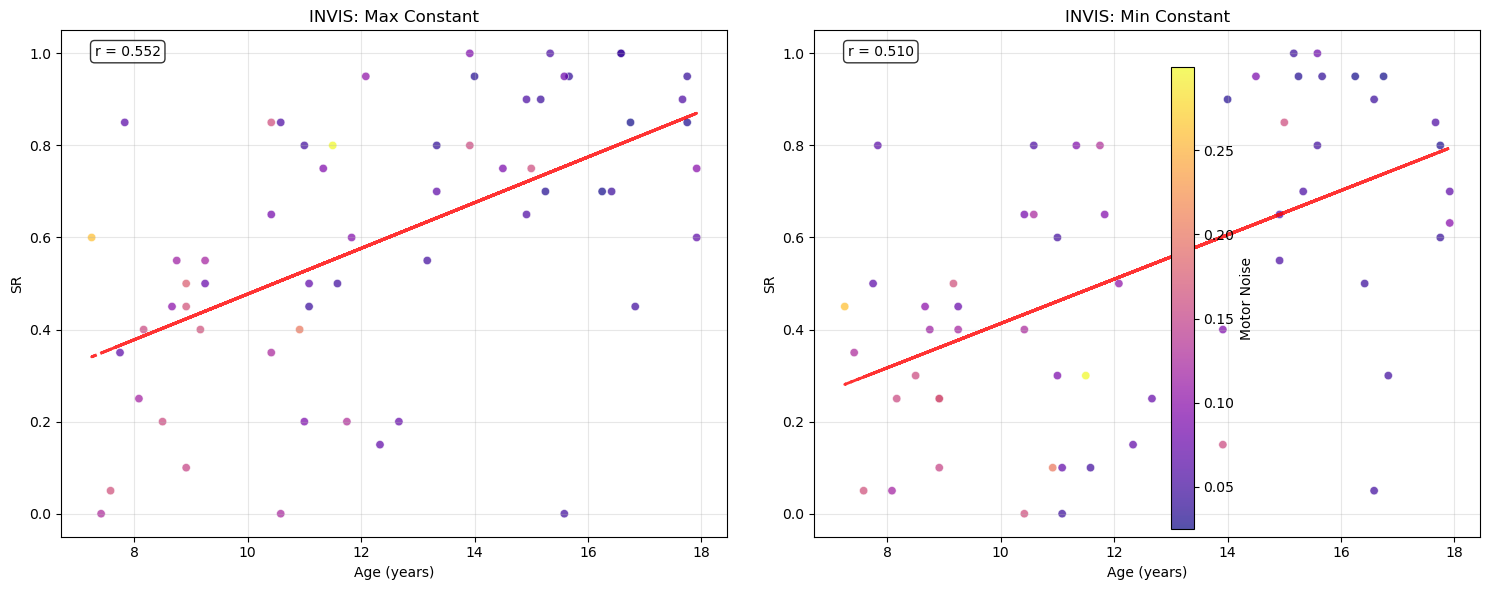

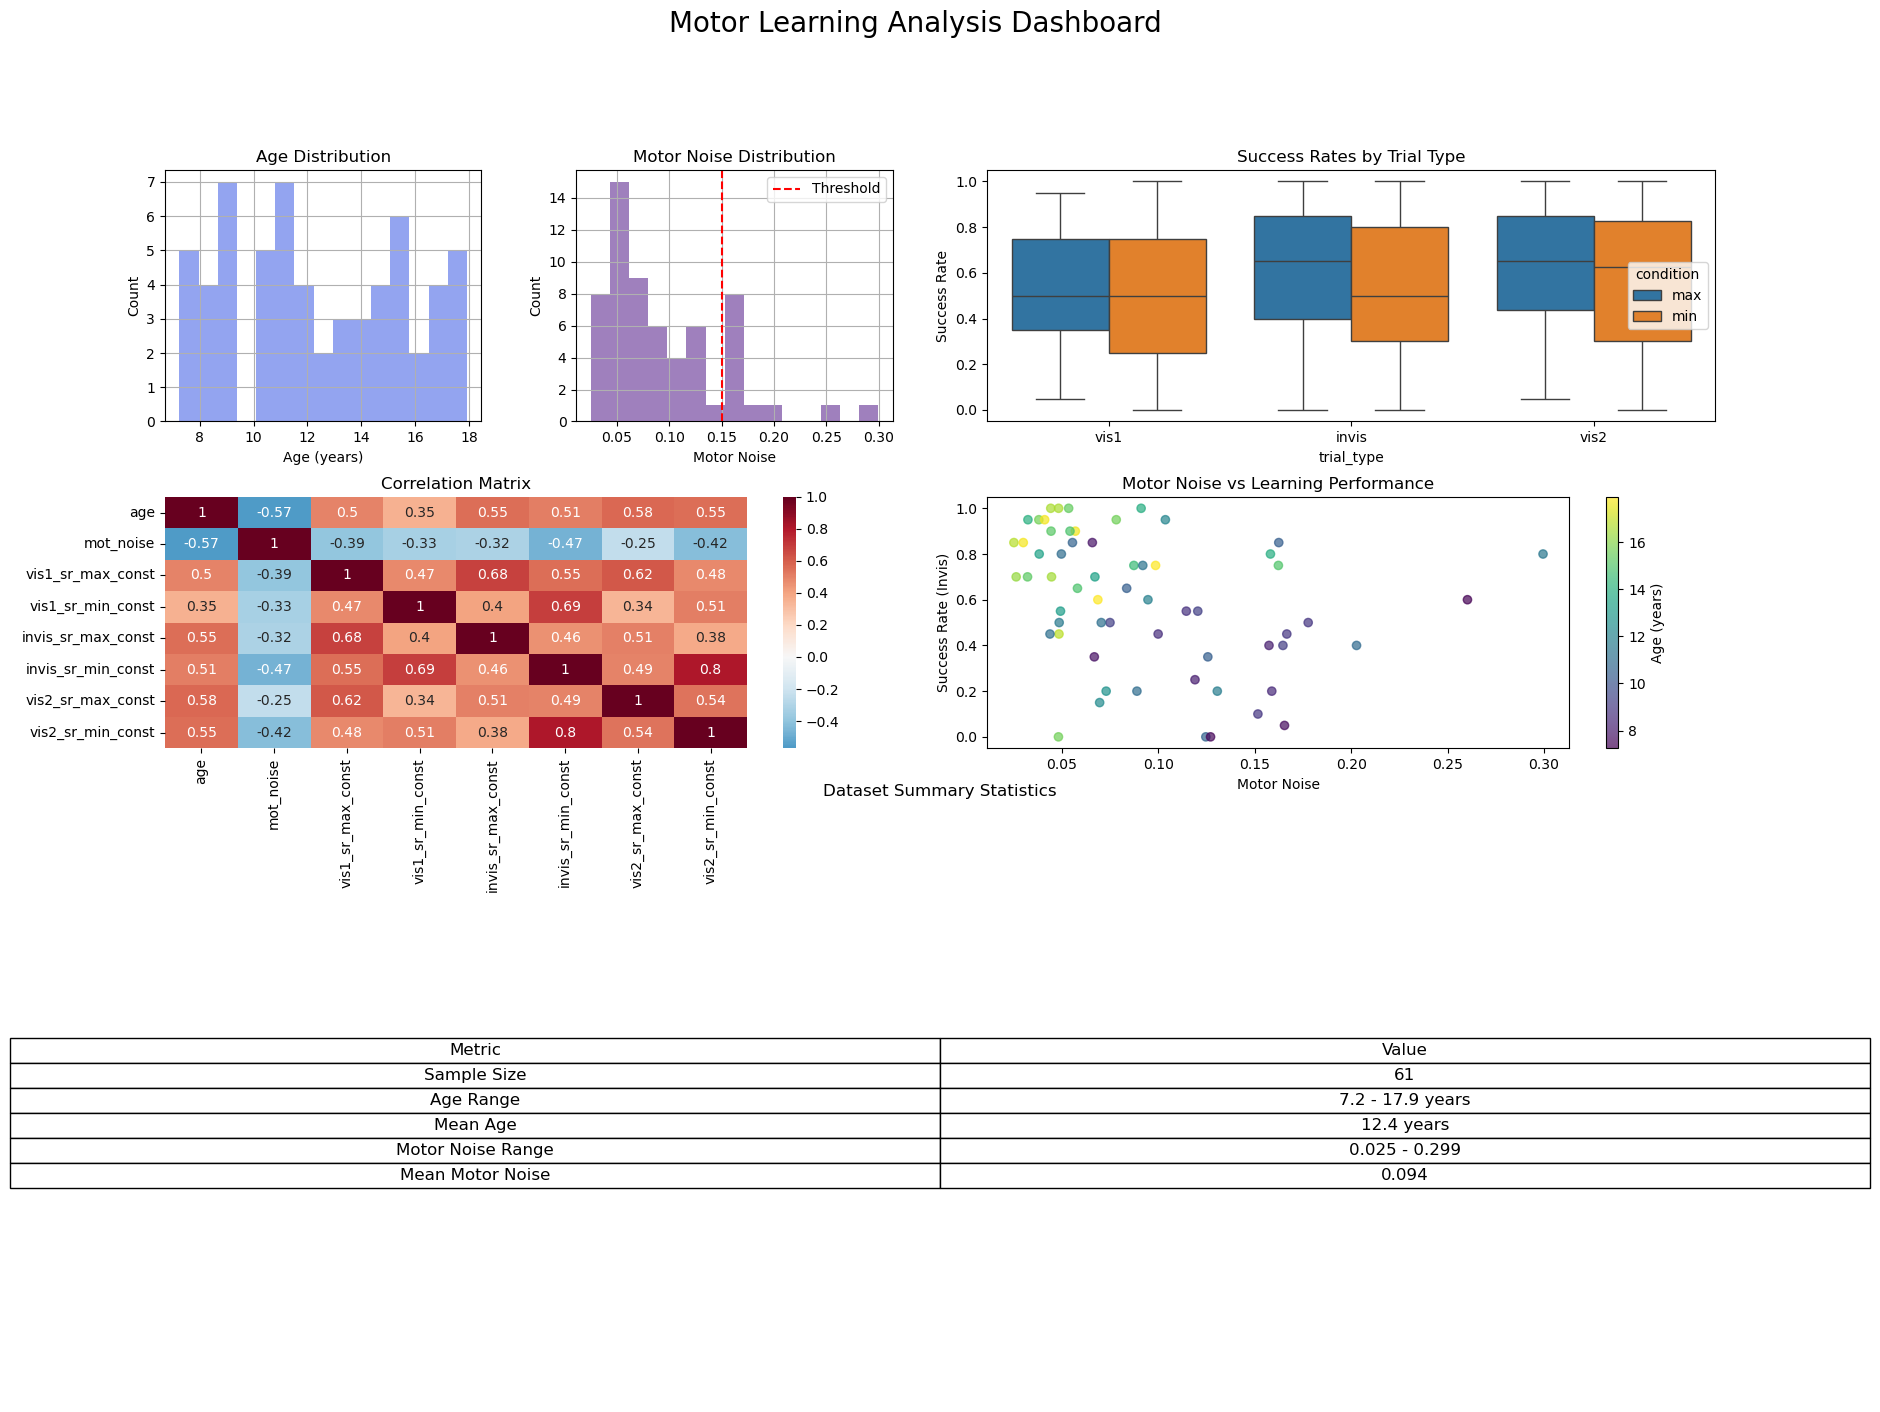

✅ Visualizations complete
🎉 Comprehensive analysis complete!
📊 Final Summary:
   Total subjects analyzed: 63
   Age range: 7.2 - 17.9 years
   Mean age: 12.5 ± 3.2 years
   Success rate metrics: 6 columns
   Figures saved to: figures
   🎯 Key finding: Age effect = 0.1457 per year

🆕 NEW FEATURE: Individual stride change distribution plotting
   Use: analysis.visualizer.plot_individual_stride_change_distribution('SUBJECT_ID', 'TRIAL_TYPE')
   Example: analysis.visualizer.plot_individual_stride_change_distribution('MUH1172', 'vis2')

🆕 DEMONSTRATING NEW STRIDE CHANGE ANALYSIS FEATURE
🔍 Demonstrating Individual Stride Change Distribution Analysis...

📊 Analyzing subject: MUH1172
   🎯 Plotting vis1 trial...


C:\Users\Nick\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\Nick\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


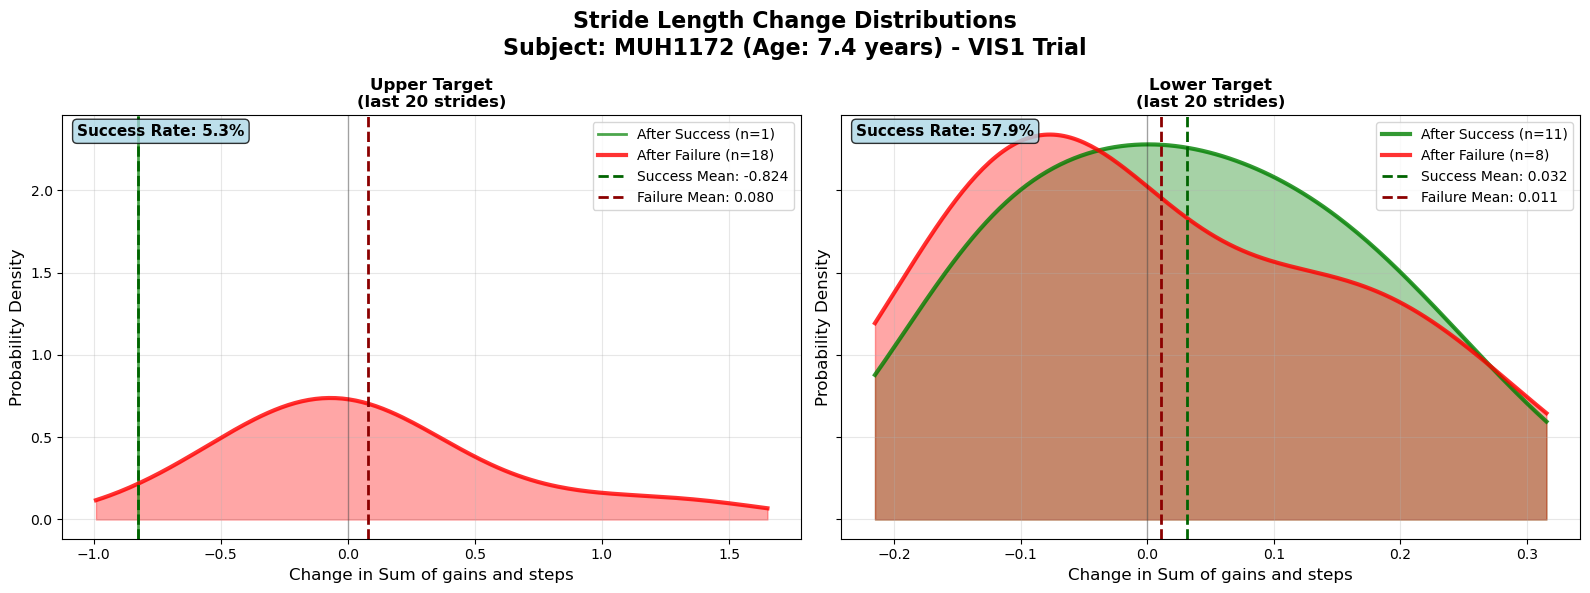

      ✅ Analysis complete for MUH1172 vis1
   🎯 Plotting invis trial...


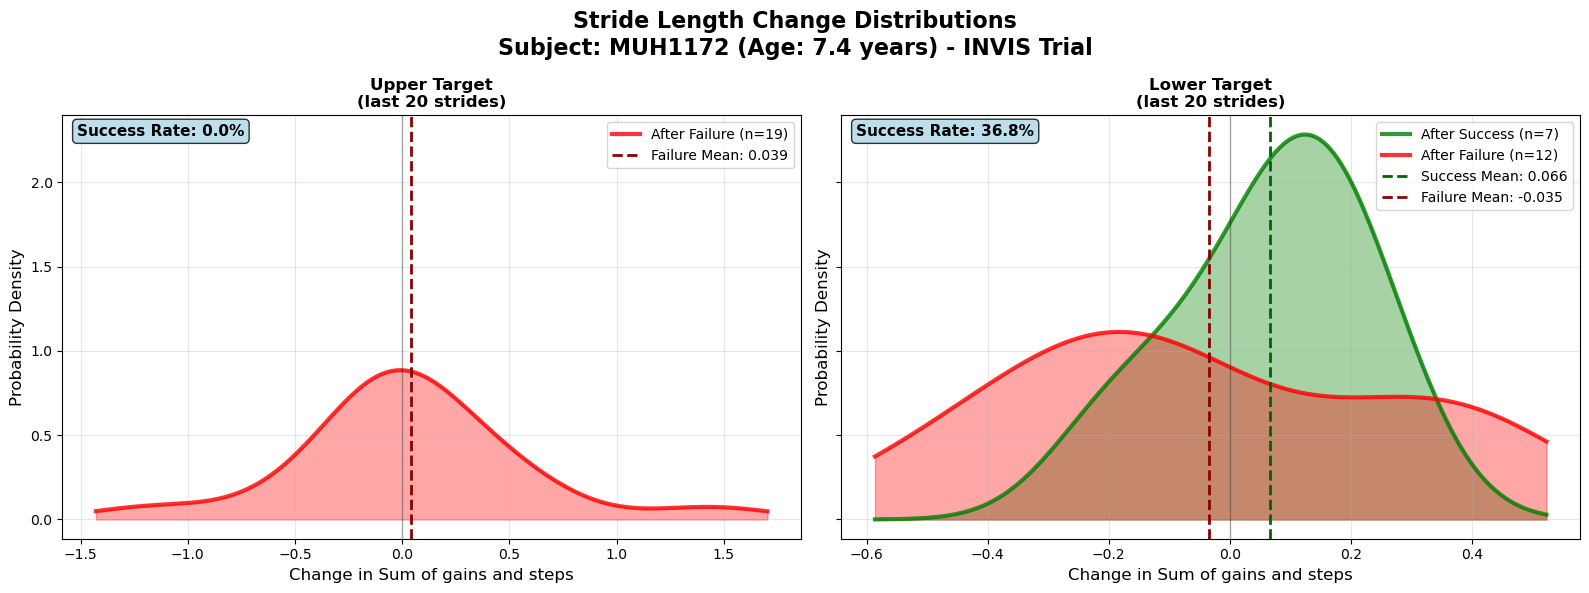

      ✅ Analysis complete for MUH1172 invis
   🎯 Plotting vis2 trial...


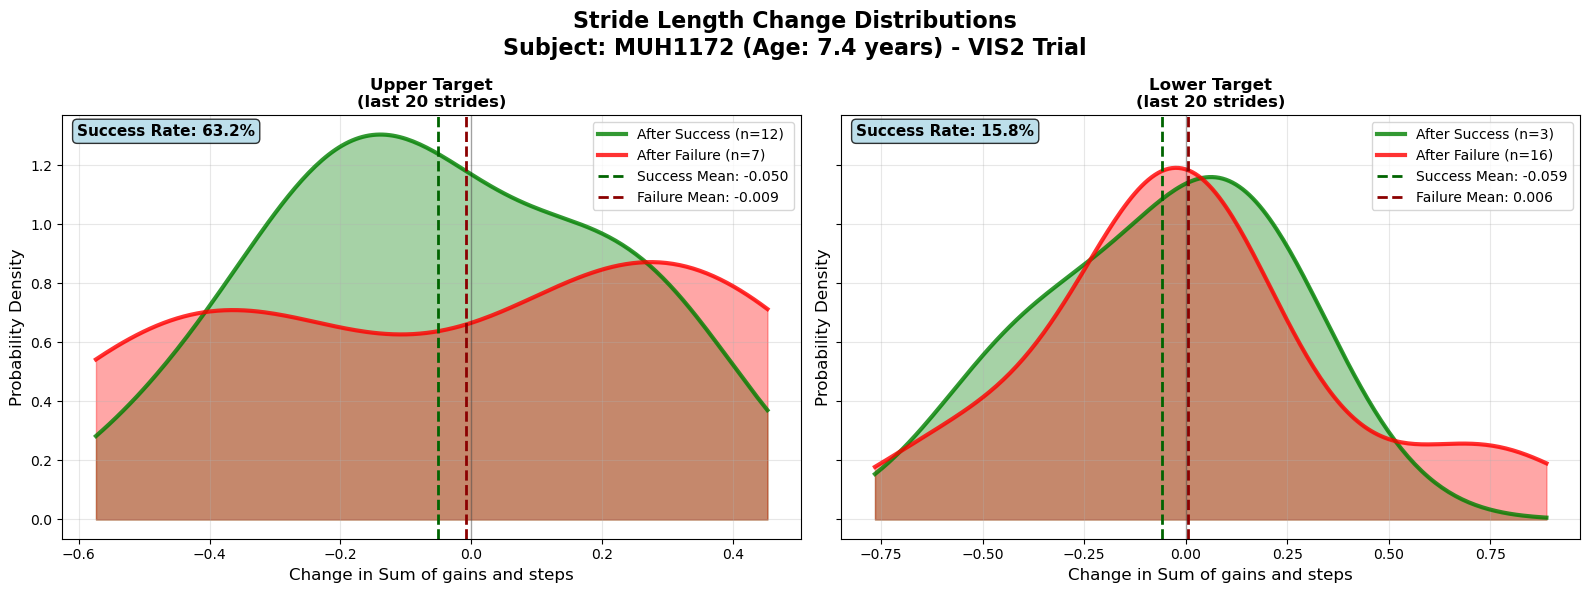

      ✅ Analysis complete for MUH1172 vis2

✅ Enhanced analysis complete!
📊 All standard analyses completed
🆕 Individual stride change distribution analysis demonstrated
📁 All figures saved to: figures

📖 HOW TO USE THE NEW STRIDE ANALYSIS FEATURE:
# Plot stride change distribution for any subject and trial:
analysis.visualizer.plot_individual_stride_change_distribution('MUH1172', 'vis2')

# Parameters you can adjust:
# - subject_id: Any subject ID from your dataset
# - trial_type: 'vis1', 'invis', or 'vis2'
# - stride_col: Column to analyze (default: 'Sum of gains and steps')
# - save: Whether to save the figure (default: True)
# - show_stats: Whether to print detailed statistics (default: True)
# - figsize: Size of the figure (default: (16, 6))
# - alpha: Transparency of the filled areas (default: 0.7)


In [ ]:
# 11. SIMPLE USAGE WITH NEW FEATURES
# ==============================================================================

if __name__ == "__main__":
    # Use your existing data paths
    metadata_path = 'muh_metadata.csv'
    data_root_dir = 'E:/muh_data/'  # Update this path as needed
    
    print("🚀 Running Enhanced Motor Learning Analysis...")
    
    # Run the ENHANCED analysis
    metrics_df, results, analysis = run_complete_motor_learning_analysis_enhanced(
        metadata_path, data_root_dir, force_reprocess=False
    )
    
    # Demonstrate the new stride analysis feature
    print("\n" + "="*60)
    print("🆕 DEMONSTRATING NEW STRIDE CHANGE ANALYSIS FEATURE")
    print("="*60)
    
    # Example usage of the new function
    example_subjects = ['MUH1172']  # You can add more subject IDs here
    demonstrate_stride_analysis(analysis, example_subjects)
    
    print("\n✅ Enhanced analysis complete!")
    print("📊 All standard analyses completed")
    print("🆕 Individual stride change distribution analysis demonstrated")
    print(f"📁 All figures saved to: {analysis.visualizer.figures_dir}")
    
    # Print usage instructions
    print("\n" + "="*60)
    print("📖 HOW TO USE THE NEW STRIDE ANALYSIS FEATURE:")
    print("="*60)
    print("# Plot stride change distribution for any subject and trial:")
    print("analysis.visualizer.plot_individual_stride_change_distribution('MUH1172', 'vis2')")
    print("\n# Parameters you can adjust:")
    print("# - subject_id: Any subject ID from your dataset")
    print("# - trial_type: 'vis1', 'invis', or 'vis2'")  
    print("# - stride_col: Column to analyze (default: 'Sum of gains and steps')")
    print("# - save: Whether to save the figure (default: True)")
    print("# - show_stats: Whether to print detailed statistics (default: True)")
    print("# - figsize: Size of the figure (default: (16, 6))")
    print("# - alpha: Transparency of the filled areas (default: 0.7)")